<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Anomaly_Detection_Techniques_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An outlier is an observation with at least one variable having an unusual value.

A univariate outlier is an observation with a variable that has an unusual value.

A multivariate outlier is an observation with at least two variables having unusual values.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ps

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
filepath='https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/Mall_Customers.csv'
df= pd.read_csv(filepath)

In [ ]:
df=df.drop('CustomerID',axis=1)
df=df.rename(columns={'Annual Income (k$)':'Income','Spending Score (1–100)':'Spend_Score'})

In [15]:
df.head()

,Genre,Age,Income,Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [7]:
data =pd.get_dummies(df)
num=data.copy()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
num2 = scaler.fit_transform(num)
num2 = pd.DataFrame(num2, columns = num.columns)

https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

This is a clustering algorithm (an alternative to K-Means) that clusters points together and identifies any points not belonging to a cluster as outliers. It’s like K-means, except the number of clusters does not need to be specified in advance.


In [11]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps = .2,metric="euclidean",min_samples = 5,n_jobs = -1)
clusters = outlier_detection.fit_predict(num2)

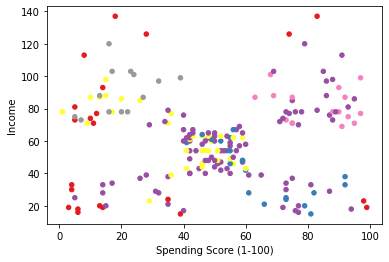

In [16]:
from matplotlib import cm
cmap = cm.get_cmap('Set1')
num.plot.scatter(x='Spending Score (1-100)',y='Income', c=clusters, cmap=cmap,colorbar = False)

Isolation Forest

In [19]:
from sklearn.ensemble import IsolationForest
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
clf.fit(num2)
if_scores = clf.decision_function(num2)
if_anomalies=clf.predict(num2)
if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
if_anomalies=num2[if_anomalies==1];


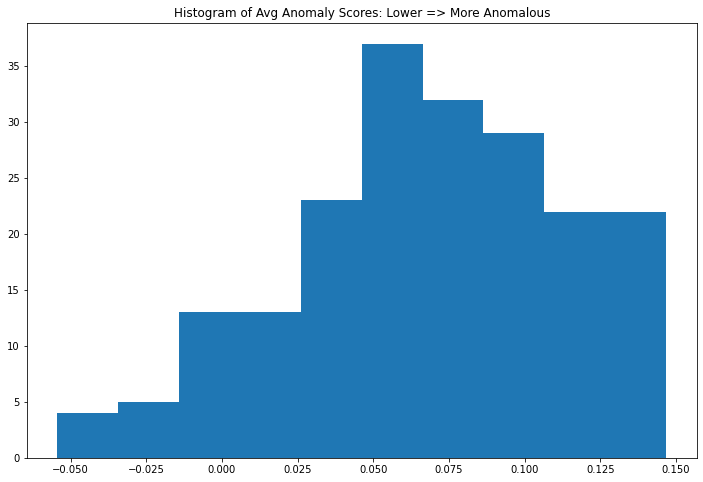

In [21]:
plt.figure(figsize=(12,8))
plt.hist(if_scores);
plt.title('Histogram of Avg Anomaly Scores: Lower => More Anomalous');

Text(0.5, 1.0, 'Isolation Forests - Anomalies')

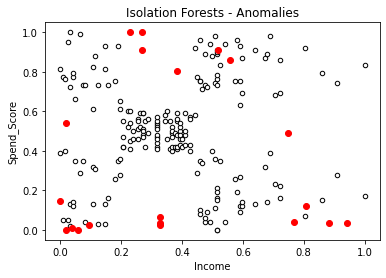

In [22]:
cmap=np.array(['white','red'])
plt.scatter(num2.iloc[:,1],num2.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(if_anomalies.iloc[:,0],if_anomalies.iloc[:,1],c='red')
plt.xlabel('Income')
plt.ylabel('Spend_Score')
plt.title('Isolation Forests - Anomalies')


Local Outlier Factor


LOF uses density-based outlier detection to identify local outliers, points that are outliers with respect to their local neighborhood, rather than with respect to the global data distribution. The higher the LOF value for an observation, the more anomalous the observation.
This is useful because not all methods will not identify a point that’s an outlier relative to a nearby cluster of points (a local outlier) if that whole region is not an outlying region in the global space of data points.
A point is labeled as an outlier if the density around that point is significantly different from the density around its neighbors.


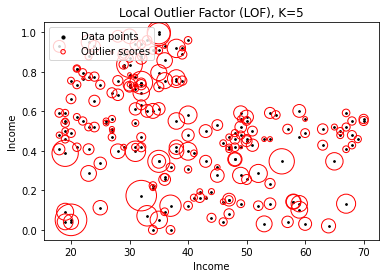

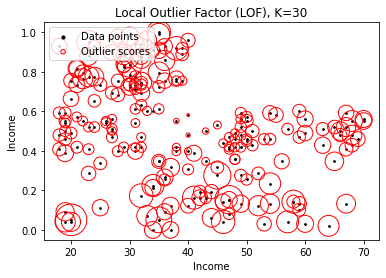

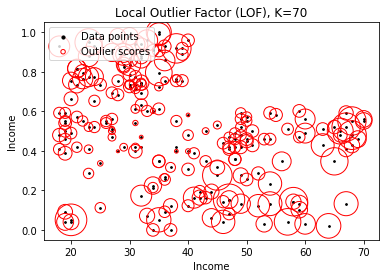

In [25]:
def LOF_plot(k):
  import seaborn as sns
  from sklearn.neighbors import LocalOutlierFactor
  var1,var2=1,2
  clf = LocalOutlierFactor(n_neighbors=k, contamination=.1)
  y_pred = clf.fit_predict(num2)
  LOF_Scores = clf.negative_outlier_factor_
 
  plt.title("Local Outlier Factor (LOF), K={}".format(k))
  plt.scatter(df.iloc[:, var1], num2.iloc[:, var2], color='k', s=3., label='Data points')
  radius = (LOF_Scores.max() - LOF_Scores) / (LOF_Scores.max() - LOF_Scores.min())

  plt.scatter(df.iloc[:, var1], num2.iloc[:, var2], s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')
  plt.axis('tight')
  plt.ylabel("{}".format(num2.columns[var1]))
  plt.xlabel("{}".format(df.columns[var2]))
  legend = plt.legend(loc='upper left')
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show();


LOF_plot(5)
LOF_plot(30)
LOF_plot(70)

In [26]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=30, contamination=.1)
y_pred = clf.fit_predict(num2)
LOF_Scores = clf.negative_outlier_factor_
LOF_pred=pd.Series(y_pred).replace([-1,1],[1,0])
LOF_anomalies=num2[LOF_pred==1]


Text(0, 0.5, 'Spend_Score')

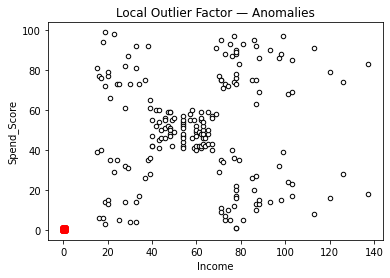

In [27]:
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(LOF_anomalies.iloc[:,1],LOF_anomalies.iloc[:,2],c='red')
 #,marker=’x’,s=100)
plt.title('Local Outlier Factor — Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')

Elliptic Envelope

The Elliptic Envelope method fits a multivariate gaussian distribution to the dataset. Use the contamination hyperparameter to specify the percentage of observations the algorithm will assign as outliers.


In [29]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=.1,random_state=0)
clf.fit(num2)
ee_scores = pd.Series(clf.decision_function(num2)) 
ee_predict = clf.predict(num2)

Text(0, 0.5, 'Spend_Score')

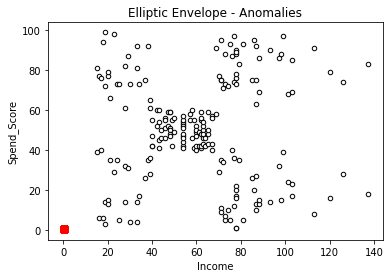

In [31]:
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(num2.iloc[:,1],num2.iloc[:,2],c='red')#,marker='x',s=100)
plt.title('Elliptic Envelope - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')


One-Class Support Vector Machines

I have not fully looked into this method, but here is a basic implementation. The nu hyperparameter seems to be like the contamination hyperparameter in other methods. It sets the % of observations the algorithm will identify as outliers.


In [35]:
from sklearn import svm
clf=svm.OneClassSVM(nu=.2,kernel='rbf',gamma=.001)
clf.fit(num2)
y_pred=clf.predict(num2)


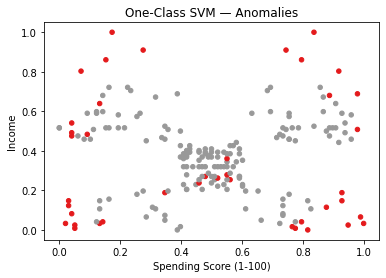

In [45]:
from matplotlib import cm
cmap = cm.get_cmap('Set1')
num2.plot.scatter(x='Spending Score (1-100)',y='Income', c=y_pred, cmap=cmap,colorbar = False)
plt.title('One-Class SVM — Anomalies');